In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
Base = automap_base()

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)


# reflect the tables
Base.classes.keys()


['measurement', 'station']

In [12]:
# We can view all of the classes that automap found
session = Session(bind=engine)

Station = Base.classes.station
Measurement = Base.classes.measurement

first_row = session.query(Station).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19fc88cf828>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19fc88cf518>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [13]:
# Create our session (link) from Python to the DB

conn = engine.connect()

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
data = pd.read_sql("SELECT max(date) as final_date FROM measurement ", conn)
last_date = data.iloc[0].tolist()
datetimeObj = datetime.strptime(last_date[0], '%Y-%m-%d')
year = datetimeObj.strftime("%Y")
year = int(year) -1
new_year = str(year) + '-' + datetimeObj.strftime("%m") + '-' + datetimeObj.strftime("%d")
print(new_year)

# Perform a query to retrieve the data and precipitation scores
query = f"SELECT date, prcp FROM measurement where date > '{new_year}'"
print(query)

# Save the query results as a Pandas DataFrame and set the index to the date column

data = pd.read_sql(query, conn)

data.set_index('date',inplace=True)

# Sort the dataframe by date

data.sort_index(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
data.dropna(inplace=True)


2016-08-23
SELECT date, prcp FROM measurement where date > '2016-08-23'


In [15]:
data.head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


C:\Users\Bill\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Precipitation'}, xlabel='date'>

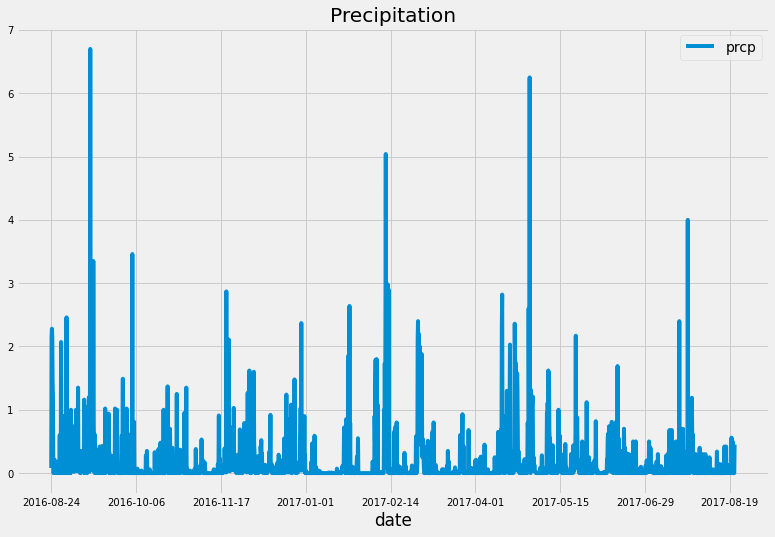

In [25]:
data.plot(kind='line',figsize=(12,8),title='Precipitation',stacked=True,fontsize=10)

In [31]:
dates = data.index.get_level_values('date').unique()
x_axis = np.arange(len(dates))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

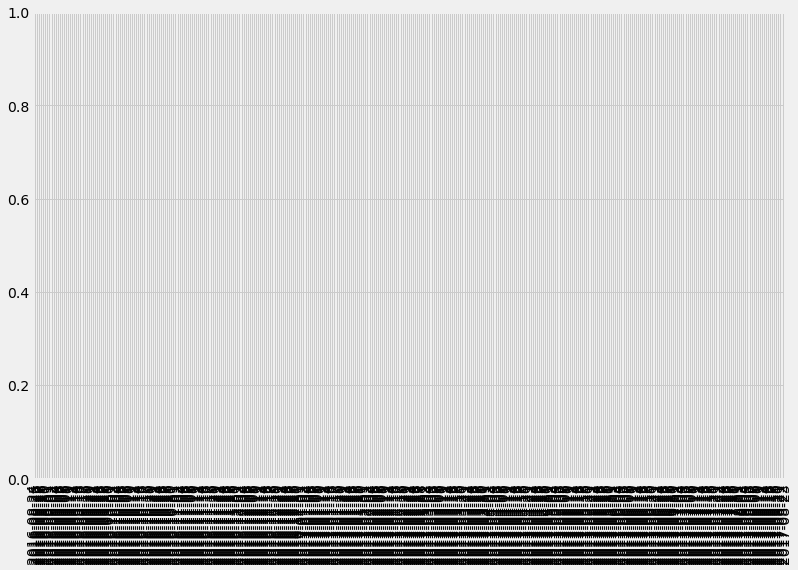

In [34]:
# data.index.get_level_values('date')

# Tell matplotlib where we would like to place each of our x axis headers
tick_locations = [value for value in x_axis]
#tick_locations


fig= plt.figure(figsize=(12,8))
plt.xticks(tick_locations, dates, rotation=90)
plt.bar(x_axis,data['prcp'])

plt.xlabel('Date')
plt.ylabel('Inches of Rain')
plt.title('Precipitation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

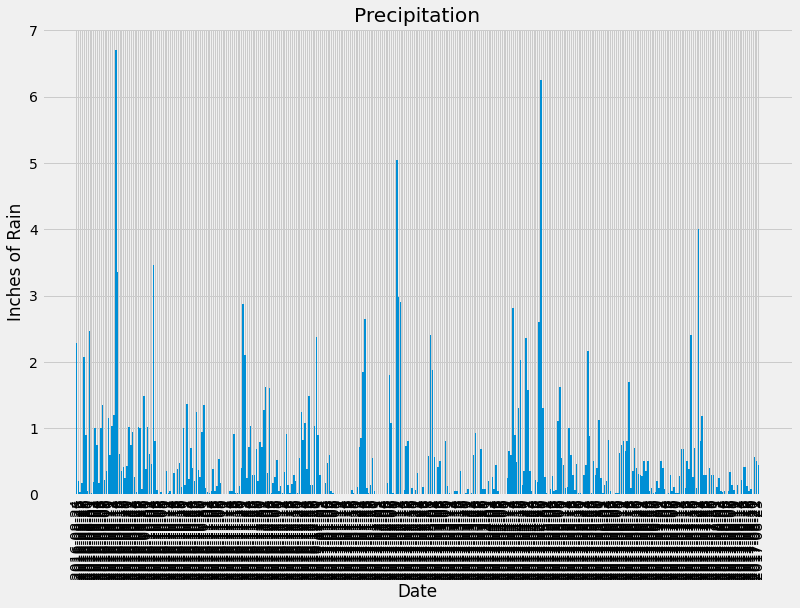

In [35]:
fig= plt.figure(figsize=(12,8))
plt.xticks(rotation=90)
plt.bar(data.index.get_level_values('date'),data['prcp'])

plt.xlabel('Date')
plt.ylabel('Inches of Rain')
plt.title('Precipitation')
plt.show

In [79]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,tobs
count,2223.000000
mean,74.578947
std,4.612232
min,58.000000
25%,71.000000
50%,75.000000
75%,78.000000
max,87.000000


In [43]:
# Design a query to show how many stations are available in this dataset?
station_count = pd.read_sql("SELECT count(station) as 'Station Count' from station", conn)
station_count.set_index("Station Count",inplace=True)
station_count.head()

""
Station Count
9


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active = pd.read_sql("SELECT station, count(station) as Station_count from measurement group by station order by Station_count desc", conn)
active.head(10)


,station,Station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps = pd.read_sql("SELECT station, min(tobs) as 'Lowest Temperature', max(tobs) as 'Maximum Temperature', AVG(tobs) as 'Average Temperature', count(tobs) as Number_of_readings from measurement group by station order by Number_of_readings desc", conn)
temps.head(10)


,station,Lowest Temperature,Maximum Temperature,Average Temperature,Number_of_readings
0,USC00519281,54.0,85.0,71.663781,2772
1,USC00519397,56.0,87.0,74.553231,2724
2,USC00513117,59.0,85.0,72.689184,2709
3,USC00519523,56.0,85.0,74.543649,2669
4,USC00516128,58.0,84.0,70.915008,2612
5,USC00514830,58.0,85.0,74.873297,2202
6,USC00511918,53.0,87.0,71.615968,1979
7,USC00517948,58.0,87.0,74.684402,1372
8,USC00518838,58.0,83.0,72.724070,511


In [90]:
#temps.query('index == 0',inplace=True)
# get the top row of the dataframe
row = next(temps.iterrows())[1]

# pull the station from the top row
top_station=row['station']

In [99]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#new_year is still valid from above.  top_station was calculated in the cell above.  Print out the query to confirm what is
# being done.

query = f"SELECT date, tobs FROM measurement where (station = '{top_station}' ) and (date > '{new_year}')"
print(query)

# Pull the data from the sqlite database.
tobs_df = pd.read_sql(query, conn)


SELECT date, tobs FROM measurement where (station = 'USC00519281' ) and (date > '2016-08-23')


In [100]:
# View of the date pulled from the database.
tobs_df.head()
tobs_df.count()


date    351
tobs    351
dtype: int64

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <BarContainer object of 12 artists>)

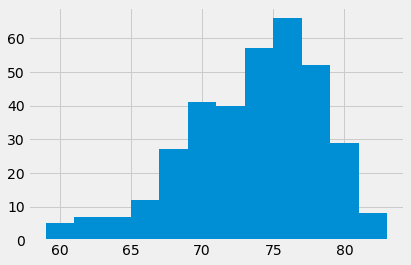

In [101]:

n_bins = 12

x = tobs_df['tobs']
y = tobs_df['tobs'].count()

plt.hist(x,bins=n_bins)



## Bonus Challenge Assignment

In [106]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
